In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from sklearn.metrics import f1_score
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt

Data-reuploading classifier
===========================

*Author: Shahnawaz Ahmed (<shahnawaz.ahmed95@gmail.com>). Last updated:
19 Jan 2021.*

A single-qubit quantum circuit which can implement arbitrary unitary
operations can be used as a universal classifier much like a single
hidden-layered Neural Network. As surprising as it sounds,
[Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) discuss
this with their idea of 'data reuploading'. It is possible to load a
single qubit with arbitrary dimensional data and then use it as a
universal classifier.


In [2]:
# from dataset import read_dataset, divide_dataset, balance_dataset

# # read the data
# dataset = read_dataset()

# # extract a balances subset containing a limited number of points
# # npts = 180
# # dataset = balance_dataset(dataset, npts)

# # only consider a subset of the features
# features = [0,1,2,3,4]
# nfeatures = len(features)
# dataset.features = dataset.features[:,features]

# # normalize the data between 0 and 2pi
# dataset.features -= dataset.features.min(0)
# dataset.features /= dataset.features.max(0)
# dataset.features *= 1

# # make int labels 
# dataset.labels = np.array(dataset.labels.astype(int), requires_grad=False)

# dataset.features = np.array(dataset.features, requires_grad=False)

# # divide the dataset in train/test
# train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)
 
# # label
# label_0 = [[1], [0]]
# label_1 = [[0], [1]]
# state_labels = np.array([label_0, label_1], requires_grad=False)

# # plot the data
# plt.scatter(train_dataset.features[:,2],train_dataset.features[:,3],c=train_dataset.labels)
# plt.scatter(test_dataset.features[:,2],test_dataset.features[:,3],c=test_dataset.labels)

In [4]:
import h5py

filename = "../data_apertif.hdf5"
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[2]
    labels = f[a_group_key][()]

    a_group_key = list(f.keys())[1]
    data = f[a_group_key][()] 

Keys: <KeysViewHDF5 ['data_dm_time', 'data_freq_time', 'labels', 'multibeam_snr', 'params', 'snr']>


In [5]:
data_subset = data[0::60,:,:] 
labels_subset = labels[0::60]
print (data_subset.shape, labels_subset.shape)

(1120, 32, 250) (1120,)


In [6]:
#Subtract median in the frequency channel
data_wo_median = np.zeros(data_subset.shape)
median = np.median(data_subset, axis=1)
data_wo_median = data_subset - median[:, np.newaxis,:]

#Divide by standard deviation
stddev = np.std(data_subset, axis=1)
data_norm = data_wo_median/stddev[:,np.newaxis,:]

#Collapse along frequency
data_collapsed = np.sum(data_norm, axis=1)

0


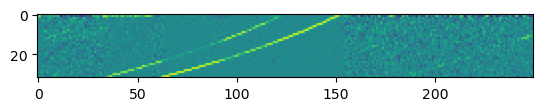

In [11]:
i=10
print (labels_subset[i])
plt.imshow(data_norm[i,:,:])

1


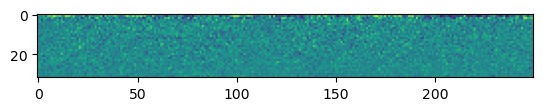

In [12]:
j = 10
print (labels_subset[-j])
plt.imshow(data_norm[-j,:,:])

In [13]:
from scipy.stats import kurtosis, skew
features = np.zeros([data_collapsed.shape[0], 4])
features[:,0] = np.mean(data_collapsed, axis=1)
features[:,1] = np.std(data_collapsed, axis=1)
features[:,2] = kurtosis(data_collapsed, axis=1)
features[:,3] = skew(data_collapsed, axis=1)

nfeatures = features.shape[1]
npts = features.shape[0]

# normalize the data between 0 and 2pi
features -= features.min(0)
features /= features.max(0)
features *= 1

# make int labels
labels_subset = np.array(labels_subset.astype(int), requires_grad=False)

features = np.array(features, requires_grad=False)

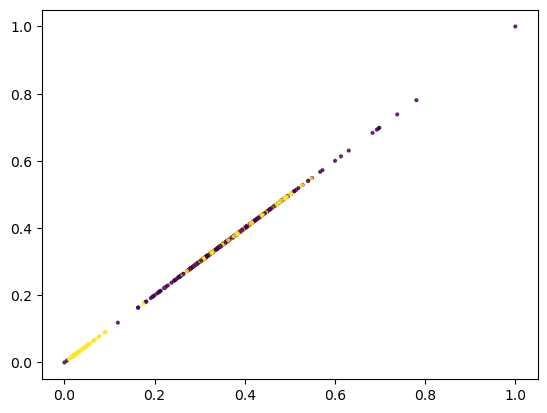

In [25]:
from dataset import DataSet, divide_dataset

dataset = DataSet(npts = npts, features= features[:,0:3], labels= labels_subset)

# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=True)

# label
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

# plot the data
plt.scatter(train_dataset.features[:,2],train_dataset.features[:,2],c=train_dataset.labels,alpha=0.75,s=4)
# plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

In [8]:
# #Oversample with smote
# from imblearn.over_sampling import SMOTE, ADASYN
# X_resampled, y_resampled = SMOTE().fit_resample(train_dataset.features, train_dataset.labels)
# print (np.count_nonzero(train_dataset.labels),np.count_nonzero(y_resampled))
# train_dataset.features = X_resampled
# train_dataset.labels = y_resampled
# train_dataset.npts = y_resampled.shape[0]

# # make int labels 
# train_dataset.labels = np.array(train_dataset.labels.astype(int), requires_grad=False)

# train_dataset.features = np.array(train_dataset.features, requires_grad=False)

# fig, axes = plt.subplots(train_dataset.features.shape[1], train_dataset.features.shape[1], figsize=(10,10), sharex=True, sharey=True)
# for i in range(train_dataset.features.shape[1]):
#     for j in range(train_dataset.features.shape[1]):
#         axes[i, j].scatter(train_dataset.features[:,i],train_dataset.features[:,j],c=train_dataset.labels,alpha=0.5,s=2)

# fig.tight_layout()

Simple classifier with data reloading and fidelity loss
=======================================================


In [26]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    
    n_inp_bloc = -(len(x)//-3)
    
    for p in params:
        for i in range(n_inp_bloc):
            qml.Rot(*x[i*3:(i+1)*3], wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [27]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    fscore = f1_score(y_true, y_pred)
    
    return score.sum() / len(y_true), fscore


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]
        
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

Train a quantum classifier on the circle dataset
================================================


In [28]:
def pad_data(data):
    if data.shape[1]%3 != 0:
        nadd = 3-data.shape[1]%3
        data = np.hstack((data, np.zeros((data.shape[0], nadd), requires_grad=False)))
    return data

In [29]:
# Generate training and test data)
X_train = pad_data(train_dataset.features)
y_train = train_dataset.labels


X_test = pad_data(test_dataset.features)
y_test = test_dataset.labels

# # Train using Adam optimizer and evaluate the classifier
# num_layers = 3
# learning_rate = 0.1
# epochs = 10
# batch_size = 32

# opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
# params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

# print(qml.draw(qcircuit)(params, X_train[1,:], y_train[0]))



In [41]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 5
learning_rate = 0.5
epochs = 20
batch_size = 64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train, f1_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test, f1_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Train F1: {:3f} | Test Accuracy: {:3f} | Test F1: {:3f}".format(
        0, loss, accuracy_train, f1_train, accuracy_test, f1_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train, f1_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test, f1_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, f1_train, accuracy_test, f1_test]
    print(
        "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Train F1: {:3f} | Test Accuracy: {:3f} | Test F1: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.374596 | Train accuracy: 0.500000 | Train F1: 0.008850 | Test Accuracy: 0.513393 | Test F1: 0.018018
Epoch:  1 | Cost: 0.244175 | Train accuracy: 0.503348 | Train F1: 0.386207 | Test Accuracy: 0.415179 | Test F1: 0.276243
Epoch:  2 | Cost: 0.277138 | Train accuracy: 0.503348 | Train F1: 0.669145 | Test Accuracy: 0.491071 | Test F1: 0.658683
Epoch:  3 | Cost: 0.251605 | Train accuracy: 0.511161 | Train F1: 0.672646 | Test Accuracy: 0.495536 | Test F1: 0.660661
Epoch:  4 | Cost: 0.229030 | Train accuracy: 0.591518 | Train F1: 0.704362 | Test Accuracy: 0.571429 | Test F1: 0.684211
Epoch:  5 | Cost: 0.222177 | Train accuracy: 0.574777 | Train F1: 0.390400 | Test Accuracy: 0.549107 | Test F1: 0.303448
Epoch:  6 | Cost: 0.225350 | Train accuracy: 0.642857 | Train F1: 0.719298 | Test Accuracy: 0.651786 | Test F1: 0.717391
Epoch:  7 | Cost: 0.222577 | Train accuracy: 0.572545 | Train F1: 0.389155 | Test Accuracy: 0.544643 | Test F1: 0.301370
Epoch:  8 | Cost: 0.225239 | Tra

Results
=======


Epoch:  0 | Cost: 0.224474 | Train accuracy: 0.655134 | Train F1: 0.712558 | Test Accuracy: 0.683036 | Test F1: 0.730038
Learned weights
Layer 0: [-0.05132545  1.27286954 -1.2387841 ]
Layer 1: [-1.07799858  0.5189822   0.03828405]
Layer 2: [ 0.47816234 -0.50344947 -0.99629122]
Layer 3: [-0.79163326  3.43416821 -2.00271198]
Layer 4: [ 0.72510339 -0.40503633  0.10089892]


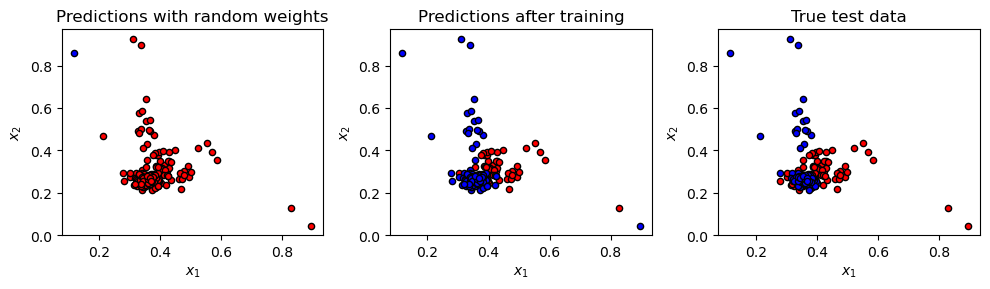

In [42]:
print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Train F1: {:3f} | Test Accuracy: {:3f} | Test F1: {:3f}".format(
        0, loss, accuracy_train, f1_train, accuracy_test, f1_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

    
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

References
==========

\[1\] Pérez-Salinas, Adrián, et al. "Data re-uploading for a universal
quantum classifier." arXiv preprint arXiv:1907.02085 (2019).

\[2\] Kingma, Diederik P., and Ba, J. "Adam: A method for stochastic
optimization." arXiv preprint arXiv:1412.6980 (2014).

\[3\] Liu, Dong C., and Nocedal, J. "On the limited memory BFGS method
for large scale optimization." Mathematical programming 45.1-3 (1989):
503-528.
